# STA663 Final Project Report

### Abstract

We implement the Bayesian hierarchical clustering algorithm described in the paper by Heller and Ghahramani (2005) and optimized the algorithm's speed using Cython. We applied the optimized algorithm to a simulated dataset and real world datasets. We compared the performance of Bayesian hierarchical clustering to a traditional hierarchical clustering and K-means clustering using a purity score of clusters.

### Background

Hierarchical clustering is an unsupervised learning algorithm that organizes data into a binary tree. By cutting the tree at various heights, one can acquire clustering structures of the data. The traditional hierarchical clustering algorithm is the  agglomerative hierarchical clustering method. This algorithm starts with each data point being in it's own cluster and uses a bottom-up approach of iteratively merging the most similar clusters until all the data has been grouped into one cluster. The similarity of clusters is evaluated using a pre-specified distance measure (e.g. Euclidean distance).

The major drawback of the traditional hierarchical clustering method is that it does not provide intuitive guidance to choosing the correct number of clusters or the appropriate distance measure. Furthermore, the algorithm does not define a probabilistic model for the data, thus it is not able to give predictions or cluster new data points into existing clusters.

Heller and Ghahramani (2005) proposed the Bayesian hierarchical clustering model to overcome those aforementioned problems. The model is similar to the traditional hierarchical clustering method, but Bayesian hierarchical clustering merges data using the marginal likelihood of data. The major advantage of Bayesian hierarchical clustering over the traditional method is that it has a natural way to choose the correct number of clusters, and it can also give predictions of the probability of assigning new data into existing clusters. On the other hand, the disadvantage of the algorithm is that it is more computationally intensive since it requires calculating the marginal likelihood at each step. Bayesian hierarchical clustering works best when the user has no prior knowledge on the number of clusters or when the user wants to predict the probability of new data belonging to any existing clusters.

### Description of algorithm

The Bayesian hierarchical clustering algorithm starts with every data point being in its own node. Afterwards, it iteratively merge the nodes with the highest merge probability until there is only a single node left (all data points in the same node). Merge probability is defined as the the ratio of the marginal likelihood of the two nodes being in the same cluster against the marginal likelihood of the nodes being partitioned in all possible ways which does not violate the existing tree structure. The tree can then be cut at the step where the merge probability is less than 50%.

In mathematical terms, if we represent the hypothesis that the nodes are in the same cluster by $H_1^k$ and the tree structure using $T$, then we can write our the algorithm:

1.Input: data = {$x^{(1)}, ..., x^{(n)}$}, model(likelihood) $p(x \mid \theta)$, prior $p(\theta \mid \beta)$

2.Initialize: number of clusters $c = n$, $D_i = $ {$x^{(i)}$} for $i = 1, ..., n$

3.while $c > 1$ do

Find the pair of clusters $D_i$ and $D_j$ that has the highest merge probability: $r_k = \frac{\pi_k p(D_k \mid H_1^k)}{p(D_k \mid T_k)}$ 
        
Merge $D_i, D_j$ into $D_k$, $T_i$, and $T_j$ into $T_k$

Delete $D_i, D_j$ and $c = c - 1$

end while

To calculate the merge probabilities, we need to compute $p(D_k \mid T_k)$, which is
$$
p(D_k \mid T_k) = \pi_k p(D_k \mid H_1^k) + (1 - \pi_k) p(D_i \mid T_i)p(D_j \mid T_j)
$$
The term $\pi_k$ can be calculated by

1.Initialize: each leaf $i$ with $d_i = \alpha, \pi_i = 1$ 

2.for each internal node $k$ do

$d_k = \alpha \Gamma(n_k) + d_{left_k}d_{right_k}$

$\pi_k = \frac{\alpha \Gamma(n_k)}{d_k}$

end for

### Optimization for performance

We optimized the algorithm using Cython. We mainly defined variables before we assigned values to them using cdef int, cdef double, and cdef np.ndarray. This led to a reduction in variables' interaction with Python, giving us an increase in speed. 

In addition to optimization, we also addressed a numerical stability issue. We realized that our initial code was raising error due to a division error. We realized that this could be fixed by taking log when calculating likelihood and other parameters. Taking log guaranteed a better numerical stability, as shown in the code below.

In [1]:
%load_ext cython

In [107]:
%%cython
import numpy as np
import itertools as it
from scipy.special import gamma
from scipy.special import multigammaln
from numpy.math cimport INFINITY
from scipy.stats import multivariate_normal
cimport numpy as np


def BHC_cython(data, log_likelihood, alpha):
    """`
    Bayesian hierarchical clustering algorithm, direct implementation from paper.
    
    Parameters
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    log_likelihood : function
        Function that returns the log marginal likelihood of data in BHC model.
    alpha : float
        Concentration parameter in model.
        
    Returns
    -------
    T_record : list(list(int))
        Cluster structure in each iteration.
    rk_record : list(float)
        Merge probability (rk) in each iteration.
    """
    
    cdef int n, c, i, j
    cdef float max_rk
    cdef int merge_index1, merge_index2
    cdef double log_pi_k, log_rk
    cdef int node_index, item_index
    cdef double log_likelihood_i, log_likelihood_j, log_likelihood_k

    
    n = data.shape[0]
    p = data.shape[1]
    c = n
    D = dict((index, Node(obs.reshape(-1, p), alpha)) for index, obs in enumerate(data))
    T = list(range(n))
    T_record = list(T)
    rk_record = [1]
    
    while c > 1:
        max_rk = -INFINITY
        node_merge = None
        merge_index1 = -1
        merge_index2 = -1
        
        for i, j in it.combinations(D.keys(), 2):
            Di = D[i]
            Dj = D[j]
            Dk = Node.merge_node(Di, Dj)
            
            log_likelihood_i = log_likelihood(Di.data)
            log_likelihood_j = log_likelihood(Dj.data)
            log_likelihood_k = log_likelihood(Dk.data)
            
            log_pi_k = Dk.log_pi_k

            log_rk = (log_pi_k + log_likelihood_k) - np.logaddexp((log_pi_k + log_likelihood_k), np.log(1 - np.exp(log_pi_k)) + log_likelihood_i + log_likelihood_j)

            if np.exp(log_rk) > max_rk:
                max_rk = np.exp(log_rk)
                node_merge = Dk
                merge_index1 = i
                merge_index2 = j
                
        #delete merged nodes and store new node
        del D[merge_index2]
        D[merge_index1] = node_merge

        #store the current tree structure and value of rk
        for item_index, node_index in enumerate(T):
            if node_index == merge_index2:
                T[item_index] = merge_index1
        T_record.append(list(T))
        rk_record.append(max_rk)
        
        c -= 1
        
    return T_record, rk_record
        

class Node(object):
    """
    Node class used in Bayesian hierarchical clustering algorithm. Main purpose is to store values of dk and pi_k for each node.
    
    Attributes
    ----------
    data : 2D numpy array
        Data with rows as observations and columns as variables.
    dk : float
        Some kind of number for computing probabilities
    pi_k : float
        For to compute merge probability
        
    Methods
    -------
    __init__(self, data, likelihood, alpha = 1)
        Instantiation operation.
    merge_node(cls, node1, node2, alpha = 1)
        Method that merges two Nodes into one new Node and return the new Node.
    """
    
    def __init__(self, data, alpha = 1, log_dk = 0, log_pi_k = 0):
        """
        Instantiation operation.
        
        Parameters
        ----------
        data : 2D numpy array
            Data with rows as observations and columns as variables.
        likelihood : function
            Function that returns the likelihood of data, sampling distribution in BHC model.
        alpha : float
            Concentration parameter in model.
        log_dk : float
            Cached probability variable. Do not define if the node is a leaf.
        log_pi : float
            Cached probability variable. Do not define if the node is a leaf.
        """
        
        #initialized according to paper
        self.data = data
        self.log_dk = log_dk
        self.log_pi_k = log_pi_k

    @classmethod
    def merge_node(cls, node1, node2, alpha = 1):
        """
        Merge two Nodes into one new Node and return the new Node.
        
        Parameters
        ----------
        node1 : Node
            First Node.
        node2 : Node
            Second Node.
        """

        cdef np.ndarray[dtype = double, ndim = 2] data
        cdef double nk
        
        data = np.vstack((node1.data, node2.data))

        nk = data.shape[0]
        log_dk = np.logaddexp(np.log(alpha) + np.log(gamma(nk)), node1.log_dk + node2.log_dk)
        log_pi_k = np.log(alpha) + np.log(gamma(nk)) - log_dk

        return cls(data, alpha, log_dk, log_pi_k)

### Applications to simulated data sets
We generated samples from a mixture of bivariate normal distributions with different means and variances, as shown in the plot below.

In [146]:
n = 10
y1 = np.random.multivariate_normal([0, 0], np.eye(2) * 0.1, n)
y2 = np.random.multivariate_normal([3, 0], np.eye(2) * 0.3, n)
y3 = np.random.multivariate_normal([0, 3], np.eye(2) * 0.5, n)
y4 = np.random.multivariate_normal([-3, 3], np.eye(2) * 0.7, n)
y5 = np.random.multivariate_normal([0, -3], np.eye(2) * 0.9, n)
simu_true_cluster = np.repeat(list(range(1, 6)), 10)

simulate_data = np.vstack((y1, y2, y3, y4, y5))

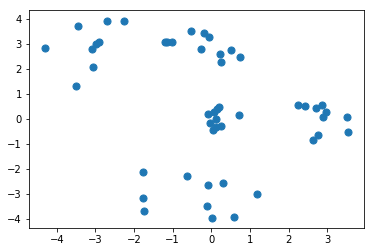

In [147]:
import matplotlib.pyplot as plt
plt.scatter(simulate_data[:, 0], simulate_data[:, 1], s = 50)
plt.show()

Next, we applied our Bayesian hierarchical clustering algorithm to this simulated dataset. Cutting the tree at $r_k < 0.5$, the algorithm identified 4 clusters. The mean cluster purity scores is around 85%. We generated the data from a Guassian mixture of 5 components, but the algorithm suggests 4 clusters. This might be due to two clusters being close to each other.

In [148]:
%matplotlib inline
import numpy as np
import pandas as pd

In [149]:
def purity_score(cluster_true, cluster_pred):
    """
    Function that returns the purity scores of each cluster given the predicted clusters and the true clusters
    """
    
    def most_common(lst):
        """Helper function that finds the most frequent item in a list"""
        return max(set(lst), key = lst.count)
    
    purity = []
    for cluster in set(cluster_pred):
        np.where(np.array(cluster_pred) == cluster)
        cluster_element = [cluster_true[index] for index in np.where(np.array(cluster_pred) == cluster)[0]]
        dominant_item = most_common(cluster_element)
        purity.append(cluster_element.count(dominant_item) / len(cluster_element))
        
    return purity

In [150]:
from scipy.special import multigammaln
import numpy as np
from numpy.linalg import slogdet

def log_Multinorm_post_marginal_likelihood(mu_0, kappa_0, nu_0, Psi_0):
    """
    Returns a function that computes the marginal likelihood 
    for a Normal-inverse-Wishart model with specifies data and prior parameters.
    """
        
    def log_marginal_likelihood(data):
        
        n = data.shape[0]
        p = data.shape[1]
        xbar = data.mean(axis = 0)
    
        #update posterior parameters
        kappa_n = kappa_0 + n
        mu_n = (kappa_0 * mu_0 + n * xbar) / kappa_n
        nu_n = nu_0 + n
    
        if (n == 1):
            C = np.zeros((p, p))
        else:
            C = (n - 1) * np.cov(data.T)
        Psi_n = Psi_0 + C + ((n * kappa_0) / (kappa_n)) * np.dot((xbar - mu_0).reshape(-1, p).T, (xbar - mu_0).reshape(-1, p))
        
        s, ldet_psi0 = slogdet(Psi_0)
        s, ldet_psin = slogdet(Psi_n)
        
        return -(n * p / 2) * np.log(np.pi) + multigammaln(nu_n / 2, p) - multigammaln(nu_0 / 2, p) + (nu_0 / 2) * ldet_psi0 - (nu_n / 2) * ldet_psin + (p / 2) * (np.log(kappa_0) - np.log(kappa_n))

    return log_marginal_likelihood


In [151]:
import BHC
p = simulate_data.shape[1]
likelihood = log_Multinorm_post_marginal_likelihood(mu_0 = np.zeros(p), kappa_0 = 1, nu_0 = p + 1, Psi_0 = np.eye(p))
BHC_clusters, rks = BHC_cython(simulate_data, likelihood, 1)

clust_n = simulate_data.shape[0] - next(x for x, val in enumerate(rks) if val < 0.5) + 1
purity_BHC_simu = np.mean(purity_score(simu_true_cluster, BHC_clusters[-clust_n]))

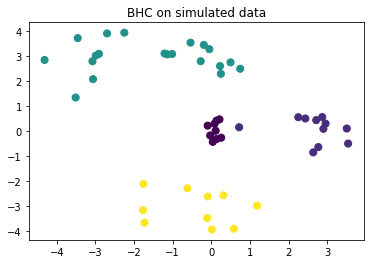

In [155]:
plt.scatter(simulate_data[:, 0], simulate_data[:, 1], c = BHC_clusters[-clust_n], s = 50)
plt.title("BHC on simulated data")
plt.show()

We compare the speeds of the original and the optimized algorithms. As one can see below, the optimized algorithm using Cython is faster by about 5%. 

In [156]:
%timeit -r3 -n1 BHC.BHC(simulate_data, likelihood, 1)

24.8 s ± 1.07 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [157]:
%timeit -r3 -n1 BHC_cython(simulate_data, likelihood, 1)

23.8 s ± 234 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Applications to real datasets
We tested our BHC algorithm on subsets of the glass dataset mentioned in the original paper, as well as the famous iris dataset by Fisher. The mean of cluster purity scores for the glass dataset is 85% and 77% for the iris dataset.

In [174]:
glass = pd.read_csv("data/glass.data", index_col=0, header=None)
iris = pd.read_csv("data/iris.data", header=None)
glass_x = np.asarray(glass.iloc[:, 0:9])
glass_y = np.asarray(glass.iloc[:, 9])
iris_x = np.asarray(iris.iloc[:, 0:4])
iris_y = np.asarray(iris.iloc[:, 4])

In [176]:
sample_index_glass = np.random.choice(glass_x.shape[0], 100, replace = False)
glass_x = glass_x[sample_index_glass, :]
glass_y = glass_y[sample_index_glass, ]

sample_index_iris = np.random.choice(iris.shape[0], 50, replace = False)
iris_x = iris_x[sample_index_iris, :]
iris_y = iris_y[sample_index_iris, ]

In [177]:
p = glass_x.shape[1]
likelihood = log_Multinorm_post_marginal_likelihood(mu_0 = np.zeros(p), kappa_0 = 1, nu_0 = p + 1, Psi_0 = np.eye(p))
glass_BHC_clusters, glass_rks = BHC_cython(glass_x, likelihood, 1)

clust_n_glass = glass_x.shape[0] - next(x for x, val in enumerate(glass_rks) if val < 0.5) + 1
purity_BHC_glass = np.mean(purity_score(glass_y, glass_BHC_clusters[-clust_n_glass]))

In [181]:
iris = pd.read_csv("data/iris.data", header=None)
iris_x = np.asarray(iris.iloc[:, 0:4])
iris_y = np.asarray(iris.iloc[:, 4])
sample_index_iris = np.random.choice(iris.shape[0], 50, replace = False)
iris_x = iris_x[sample_index_iris, :]
iris_y = iris_y[sample_index_iris, ]

In [182]:
p = iris_x.shape[1]
likelihood = log_Multinorm_post_marginal_likelihood(mu_0 = np.zeros(p), kappa_0 = 1, nu_0 = p + 1, Psi_0 = np.eye(p))
iris_BHC_clusters, iris_rks = BHC_cython(iris_x, likelihood, 1)

clust_n_iris = iris_x.shape[0] - next(x for x, val in enumerate(iris_rks) if val < 0.5) + 1
purity_BHC_iris = np.mean(purity_score(iris_y, iris_BHC_clusters[-clust_n_iris]))

### Comparative analysis with competing algorithms
In this section, we will apply the traditional hierarchical clustering with single linkage and K-means clustering to our simulated and real world datasets and compare their performance with the Bayesian hierarchical clustering algorithm we implemented.

In [185]:
#hierarchical clustering on simulated dataset
from scipy.cluster.hierarchy import linkage, cut_tree
HC = linkage(simulate_data, 'single')
HC_cluster = cut_tree(HC, clust_n)
purity_HC_simu = np.mean(purity_score(simu_true_cluster, HC_cluster.flatten()))

#k-means clustering on simulated dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = clust_n, random_state=0).fit(simulate_data)
kmeans_cluster = kmeans.labels_
purity_KM_simu = np.mean(purity_score(simu_true_cluster, kmeans_cluster))

#hierarchical clustering on glass dataset
HC = linkage(glass_x, 'single')
HC_cluster = cut_tree(HC, clust_n_glass)
purity_HC_glass = np.mean(purity_score(glass_y, HC_cluster.flatten()))

#k-means clustering on glass dataset
kmeans = KMeans(n_clusters = clust_n_glass, random_state=0).fit(glass_x)
kmeans_cluster = kmeans.labels_
purity_KM_glass = np.mean(purity_score(glass_y, kmeans_cluster))

#hierarchical clustering on iris dataset
HC = linkage(iris_x, 'single')
HC_cluster = cut_tree(HC, clust_n_iris)
purity_HC_iris = np.mean(purity_score(iris_y, HC_cluster.flatten()))

#k-means clustering on iris dataset
kmeans = KMeans(n_clusters = clust_n_iris, random_state=0).fit(iris_x)
kmeans_cluster = kmeans.labels_
purity_KM_iris = np.mean(purity_score(iris_y, kmeans_cluster))

In [188]:
purity_df = np.array([[purity_HC_simu, purity_KM_simu, purity_BHC_simu], 
                     [purity_HC_glass, purity_KM_glass, purity_BHC_glass],
                     [purity_HC_iris, purity_KM_iris, purity_BHC_iris]])
purity_df = pd.DataFrame(purity_df, columns = ("Hierarchical clustering", "K-means", "BHC"),
                        index = ("Simulated", "Glass", "Iris"))
purity_df

,Hierarchical clustering,K-means,BHC
Simulated,0.875000,0.852273,0.852273
Glass,0.846939,0.696703,0.845361
Iris,0.771429,0.733456,0.771429


According to our result, the hierarchical clustering and BHC have higher purity scores than K-means. In contrast, hierarchical clustering and BHC are similar purity scores in every dataset listed in the table. This result is different from the original paper which has BHC as the top performer in most of the dataset. Note, however, that BHC offers a better guidance to choosing the appropriate number of clusters. For this reason, BHC might still be favorable in practice.

### Conclusion

We implemented Bayesian hierarchical clustering to assess the superiority of the algorithm to the other known traditional hierarchical clustering and K-means clustering using the metric known as the cluster purity scores. 

In contrast to the original paper, we observed that BHC is not superior to the traditional hierarchical clustering in terms of the purity scores. However, with the natural choice of appropriate number of clusters and the nature of a probabilistic model, BHC may be more attractive to those who want to algorithm to provide to assist in choosing the number of clusters and predict the probability of a new data being in the existing cluster.

### References

Heller, K. A., & Ghahramani, Z. (2005). Bayesian Hierarchical Clustering. Neuroscience, 6(section 2), 297–304. doi:10.1145/1102351.1102389

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.